# Solution Exercise 5
This week, we are working on least squares fits and parameter estimation

In [0]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm, chi2, lognorm

## Fit a polynomial
We start by fitting a polynomial to a given data set, in particular, a parabola. Compare a linear fit and a cubic fit to our parabolic fit and check the goodness of fits with chi squared distributions. Explore how the different uncertainties affect the outcome and uncertainties of the fit.  (Suggestion: Checkout numpy's methods "polyfit" and "polyval")

Hint: You can consider a plot similar to the lecture notes week 5 page 13.

Extra: Do you see any way to decide wether the data is better modeled by a parabolic or a cubic function? (check error estimates and a goodness of fit)


In [0]:
# Create some data distribuited as parabola with normally distributed background noise.
def parabola(x, a, b, c):
    return a*x**2 + b*x + c
def bNoise(x, sigma):
    return norm.rvs(0.0, sigma, x.size) 
a = -0.1
b = 0
c = 1
sigma_y = 0.0015 # uncertainties on measurements done in 'y'

x = np.linspace(0, 1, 21)
y_true = parabola(x, a, b, c)
delta_y = bNoise(x, sigma_y)
y = y_true + delta_y
y_error = np.full(x.size, sigma_y)

In [0]:
def fit_polynomial(x, y, degree, weight, uncertainties=sigma_y):
    """
    Fit given data to a desired polynomial.
    :param x: is an array of points. x is the abscissa
    :param y: is an array of points of the same size as x. y is the ordinate
    :param degree: is an integer that specifies the degree of the polynomial to fit the data points (x,y)
    :param weight: is an array of the same size of y which specifies the weights to apply to the y-data
    :param unertainties: is an array of the same size of y corresponding to the uncertainty of each y measurment made
    :return: array with fit coefficients, covariance matrix, residuals, reduced chi2, degrees of freedom
    """
    dof = x.size - degree
    fit, cov = np.polyfit(x, y, degree, w=weight, cov=True)
    residuals = np.sum((y - np.polyval(fit, x))**2 / uncertainties**2)
    chisq = residuals / (dof)
    return fit, cov, residuals, chisq, dof

fit, cov, res, chisq, dof = {}, {}, {}, {}, {}
max_pol_degree = 3

for pol_deg in range(1, max_pol_degree + 1):
    fit[pol_deg], cov[pol_deg], res[pol_deg], chisq[pol_deg], dof[pol_deg] = fit_polynomial(x, y, pol_deg, 1 / y_error)


In [15]:
# Compare reduced chi2 for each fit:
print('Reduced chi^2:')
print('line', chisq[1])
print('parabola', chisq[2])
print('cubic', chisq[3])

Reduced chi^2:
line 30.301543122561498
parabola 0.8339576816549262
cubic 0.7480750610137537


In [16]:
# Evaluate goodness of fit using the reduced chi2 and dof and compare
def evaluate_chisq(chisq, dof):
    return 1-chi2.cdf(chisq, dof)

print('Chi^2 goodnsess of fit:')
print('line', evaluate_chisq(chisq[1], dof[1]))
print('parabola', evaluate_chisq(chisq[2], dof[2]))
print('cubic', evaluate_chisq(chisq[3], dof[3]))

Chi^2 goodnsess of fit:
line 0.06511270425105042
parabola 0.9999999998509987
cubic 0.9999999997178187


In [17]:
# Compare error estimates of fitted parameters (covariance matrix diagonal)
print('Error estimates:')
print('linear', np.sqrt(np.diag(cov[1])))
print('parabola', np.sqrt(np.diag(cov[2])))
print('cubic', np.sqrt(np.diag(cov[3])))

Error estimates:
linear [0.00610585 0.00356901]
parabola [0.00375858 0.00389305 0.00084006]
cubic [0.01353088 0.02060709 0.00874073 0.00098467]


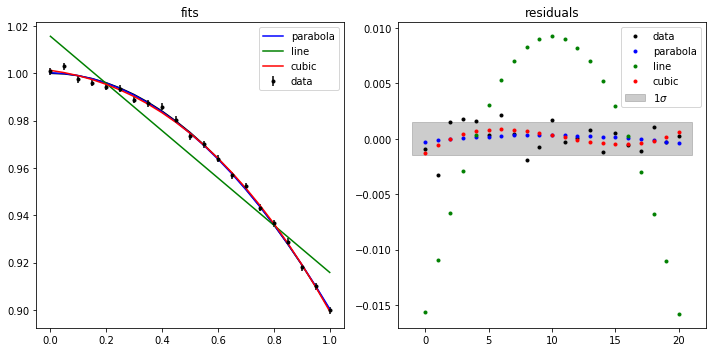

In [18]:
# Plot the fit results and their residuals
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('fits')
ax[0].errorbar(x, y, yerr=y_error, fmt='k.', label='data')
ax[0].plot(x, y_true, 'k-')
ax[0].plot(x, np.polyval(fit[2], x), label='parabola', color='blue')
ax[0].plot(x, np.polyval(fit[1], x), label='line', color='green')
ax[0].plot(x, np.polyval(fit[3], x), label='cubic', color='red')
ax[0].legend()

ax[1].set_title('residuals')
ax[1].plot(y_true - y, 'k.', label='data')
ax[1].plot(y_true - np.polyval(fit[2], x), '.', color='blue', label='parabola')
ax[1].plot(y_true - np.polyval(fit[1], x), '.', color='green', label='line')
ax[1].plot(y_true - np.polyval(fit[3], x), '.', color='red', label='cubic')
ax[1].fill_between(ax[1].get_xlim(), -sigma_y, sigma_y, color='grey', alpha=0.4, label=r'$1\sigma$')
ax[1].legend()
f.tight_layout()

We observe that the residuals are not uniformly distributed around zero with the expected variance $\sigma_y$ in the case of the line fit. This is reflected in the $\chi^2$. Only in 7% of the cases we would expect to draw data that give a worse fit. Note that overfitting with a cubic is not easily spotted in the residuals. However we do observe higher errors on the parameter estimates in the cubic case and we could try a different approach: let's fit only a subset of our data and then compare the fit results on the complement.

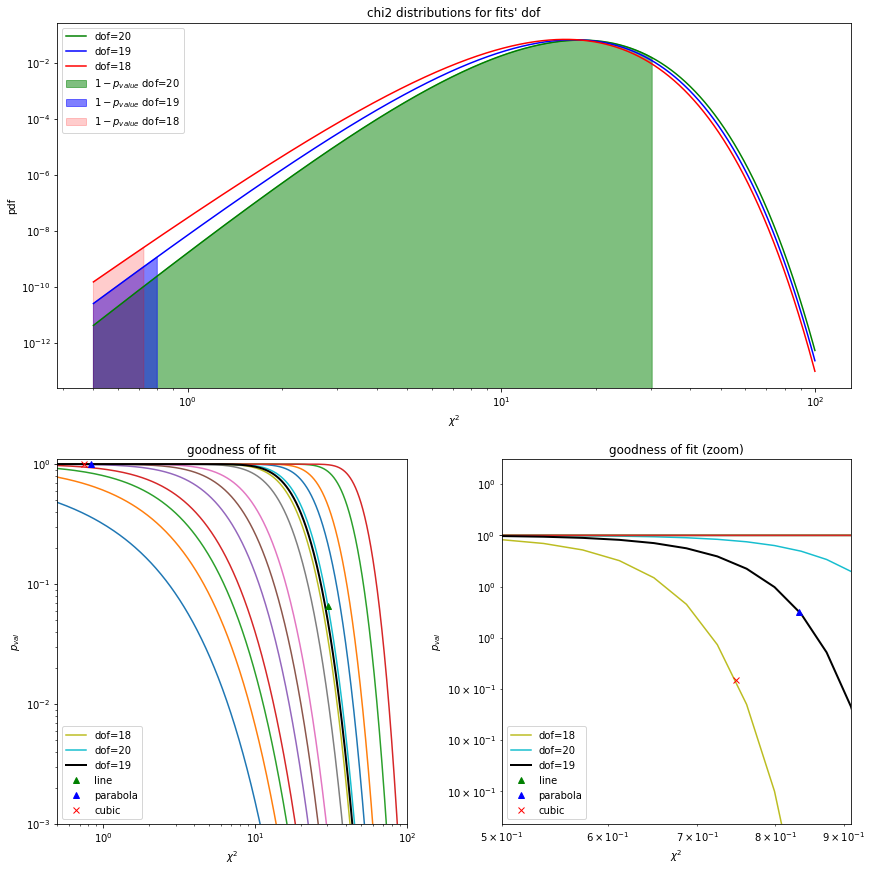

In [32]:
chisq_arr = np.arange(0.5, 100, min(chisq[2], chisq[3]) / 20.)
chisq_arr_z = np.extract(np.bitwise_and(0.5 * min(chisq[2], chisq[3])<= chisq_arr, chisq_arr <= 1.1 * max(chisq[2], chisq[3])), chisq_arr)
chi2sf = {deg: chi2.sf(chisq[deg], dof[deg]) for deg in chisq.keys()}
# Show graphically the p-values of each of the fitted models and compare them (check week 5 slide 12). It might be useful to compare 1-pvalue instead of the p-values directly
f2 = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = f2.add_gridspec(2, 2)
ax_top = f2.add_subplot(gs[0, :])
ax_top.set_title('chi2 distributions for fits\' dof')
ax_top.set_xlabel(r'$\chi^{2}$')
ax_top.set_ylabel('pdf')
ax_top.loglog(chisq_arr, chi2.pdf(chisq_arr, dof[1]), 'g-', label='dof=' + str(dof[1]))
ax_top.loglog(chisq_arr, chi2.pdf(chisq_arr, dof[2]), 'b-', label='dof=' + str(dof[2]))
ax_top.loglog(chisq_arr, chi2.pdf(chisq_arr, dof[3]), 'r-', label='dof=' + str(dof[3]))
ax_top.fill_between(chisq_arr, 0, chi2.pdf(chisq_arr, dof[1]), where=chisq_arr < chisq[1], color='green', alpha=0.5, label='$1-p_{value}$ dof='+str(dof[1]))
ax_top.fill_between(chisq_arr, 0, chi2.pdf(chisq_arr, dof[2]), where=chisq_arr < chisq[2], color='blue', alpha=0.5, label='$1-p_{value}$ dof='+str(dof[2]))
ax_top.fill_between(chisq_arr, 0, chi2.pdf(chisq_arr, dof[3]), where=chisq_arr < chisq[3], color='red', alpha=0.2, label='$1-p_{value}$ dof='+str(dof[3]))
ax_top.legend()

# Draw the plot form lecture notes week 5, page 13 and plot your chi-squares for the different fits. Hint: make a zoom to check the difference on the parabolic and cubic fits

ax_bot_l = f2.add_subplot(gs[-1, 0])
ax_bot_l.set_title('goodness of fit')
ax_bot_l.set_ylim(1e-3, 1.1)
ax_bot_l.set_xlim(0.5, 100)
ax_bot_r = f2.add_subplot(gs[-1, -1])
ax_bot_r.set_title('goodness of fit (zoom)')
ax_bot_r.set_xlim(chisq_arr_z[0], chisq_arr_z[-1])
ax_bot_r.set_ylim(2 * min(chi2sf[2], chi2sf[3]) - 1, 2 - max(chi2sf[2], chi2sf[3]))

for axis_i in [ax_bot_l, ax_bot_r]:
    axis_i.set_xlabel(r'$\chi^2$')
    axis_i.set_ylabel(r'$p_{val}$')
    for n in [1, 2, 3, 4, 6, 8, 10, 15, 18, 20, 25, 30, 40, 50]:
        axis_i.loglog(chisq_arr, chi2.sf(chisq_arr, n), label='dof=' + str(n) if n in [18, 20] else '')
    axis_i.loglog(chisq_arr, chi2.sf(chisq_arr, dof[2]), 'k-', lw=2, label='dof=' + str(dof[2]))
    axis_i.plot(chisq[1], chi2sf[1], '^', color='green', label='line')
    axis_i.plot(chisq[2], chi2sf[2], '^', color='blue', label='parabola')
    axis_i.plot(chisq[3], chi2sf[3], 'x', color='red', label='cubic')
    axis_i.legend()

As depicted on the top plot, the cubic fit (dof=18) has a bigger $1-p_{value}$ than the quadratic fit (dof=19). On the bottom plots, this is also observed using the $p_{value}$. In all the cases, it is clear that the linear fit (dof=20) has the highest probability of obtaining worse reisduals from the observed data.

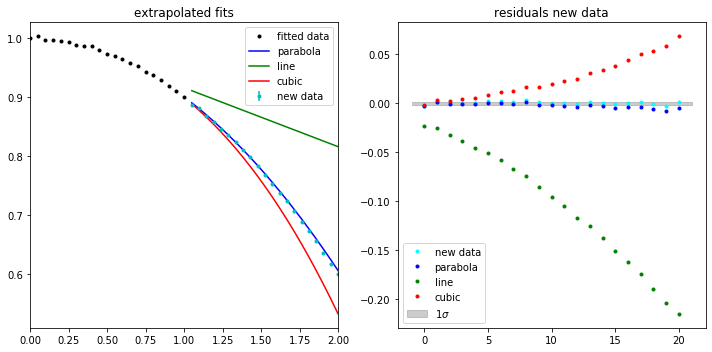

In [20]:
x_new = np.linspace(1.05, 2, 21)
y_true_new = parabola(x_new, a, b, c)
y_new = y_true_new + bNoise(x_new, sigma_y)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('extrapolated fits')
ax[0].plot(x, y, 'k.', label='fitted data')
ax[0].errorbar(x_new, y_new, yerr=y_error, fmt='c.', label='new data')

ax[0].plot(x_new, np.polyval(fit[2], x_new), label='parabola', color='blue')
ax[0].plot(x_new, np.polyval(fit[1], x_new), label='line', color='green')
ax[0].plot(x_new, np.polyval(fit[3], x_new), label='cubic', color='red')

ax[0].legend()
ax[0].set_xlim(0, 2)

ax[1].plot(y_new - parabola(x_new, a, b, c), '.', color='cyan', label='new data')
ax[1].set_title('residuals new data')
ax[1].fill_between(ax[1].get_xlim(), -sigma_y, sigma_y, color='grey', alpha=0.4, label=r'$1\sigma$')
ax[1].plot(y_new - np.polyval(fit[2], x_new), '.', color='blue', label='parabola')
ax[1].plot(y_new - np.polyval(fit[1], x_new), '.', color='green', label='line')
ax[1].plot(y_new - np.polyval(fit[3], x_new), '.', color='red', label='cubic')
ax[1].legend()
f.tight_layout()



We can see that the hypothesis of a parabola holds better against the cubic. An overfitted model usually does not describe well addtional data.

## Fit a nonlinear function
Next, we consider a Gaussian as an example of a nonlinear function. We are measuring some feature which has a Gaussian distribution in $x$. This could be an inhomogeneous spectral line for $x=E$ the energy of emitted photons. We are interested in the resonance frequency and the linewidth, i. e. we want to estimate them from our observations.

In [0]:
def gaussian_parent(x, mu, sigma):
    """
    PDF of a normal distribution
    :param x: value or array of points to evaluate the pdf
    :param mu: mean of the modeled normal distribution
    :param sigma: standard deviation of the modeled normal distribution
    :return: The value of the pdf of a normal distribution evaluated at 'x' with parameters 'mu' and 'sigma'
    """
    return norm.pdf(x, mu, sigma)    

def gaussian_sample(mu, sigma, sample_size):
    """
    Sample of points normally distributed
    :param mu: mean of the parent normal distribution
    :param sigma: standard deviation of the parent normal distribution
    :param sample_size: number of data points to generate for the sample
    :return: An array points of size 'sample_size' normally distributed (mean 'mu', standard deviation 'sigma'
    """
    return norm.rvs(mu, sigma, sample_size)

# Parent function parameters
mu = 1540
sigma = 11

In [0]:
# Create sample
## SAMPLE SIZE
sample_size = 300
##################

# Prepare fake data
mu = 1540  # True values that we will try to estimate
sigma = 11 # using a least-squares fit

x_arr = np.linspace(1500, 1600, 101)
bins = 12
sample = gaussian_sample(mu, sigma, sample_size)
hist = np.histogram(sample, bins=bins, range=(1500, 1580))
bin_width = np.diff(hist[1])[0]
normalization = bin_width * sample_size
x = hist[1][:-1]+bin_width/2
y_error_const = 0
y = hist[0]/normalization + gaussian_sample(0, y_error_const, bins)
y_errors = np.sqrt((np.sqrt(hist[0]) / normalization)**2 + y_error_const**2)

# Save data
data = np.vstack((x, y, y_errors))
np.savetxt('data', data)
np.savetxt('sample', sample)

In [0]:
## Load data from disk. Format (3,12): (x, y, y_error) x N 
data = np.loadtxt('data')
x = data[0, :]
y = data[1, :]
y_error = data[2, :]
## The sample used to generate
sample = np.loadtxt('sample')

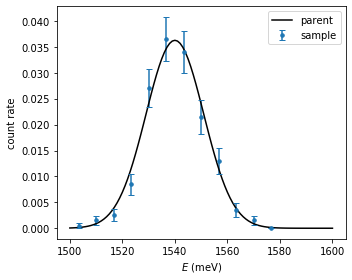

In [24]:
# Plot the measurement results
x_arr = np.linspace(1500, 1600, 101)
plt.figure(figsize=(5, 4))
plt.xlabel(r'$E$ (meV)')
plt.ylabel('count rate')
plt.plot(x_arr, gaussian_parent(x_arr, mu, sigma), '-', color='black', label='parent')
plt.errorbar(x, y, yerr=y_error, fmt='.', ms=7, capsize=3, label='sample')
plt.legend()
plt.tight_layout()

In [0]:
# Function we want to fit to our data set
def model_function(x, *args):
    """
    PDF of the modeled normal distribution
    :param  x: value or array to evaluate the normal distribution
    :param *args: array containing ['mu', 'sigma'] that describe the normal distribution
    :return: The value of the PDF of a normal distribution evaluated at 'x' with parameters 'mu' and 'sigma'
    """
    mu, sigma = args[0:2]
    return norm.pdf(x, mu, sigma)

In [26]:
# Perform the fit minimizing least squares
initial_guess = [1545, 9]
p_opt, p_cov = curve_fit(model_function, x, y, p0=initial_guess, sigma=None, absolute_sigma=False, check_finite=True)
p_err = np.sqrt(np.diag(p_cov))
# pcov(absolute_sigma=False) = pcov(absolute_sigma=True) * chisq(popt)/(M-N)
print('Fit Results:')
print('mu = {:1.1f} +- {:1.1f}'.format(p_opt[0], p_err[0]))
print('sigma = {:1.1f} +- {:1.1f}'.format(p_opt[1], p_err[1]))

print('Estimators from data:')
print('mu estimator = {:1.1f} +- {:1.1f}'.format(np.mean(sample), np.std(sample, ddof=1)/np.sqrt(sample.size)))
print('sigma estimator = {:1.1f}'.format(np.std(sample, ddof=1)))

Fit Results:
mu = 1539.6 +- 0.4
sigma = 10.7 +- 0.3
Estimators from data:
mu estimator = 1540.0 +- 0.6
sigma estimator = 10.9


### Plot the result

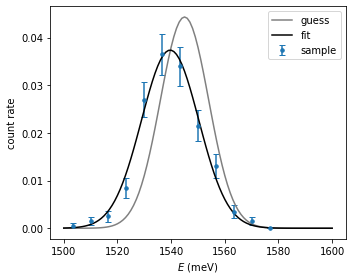

In [27]:
x_arr = np.linspace(1500, 1600, 101)

plt.figure(figsize=(5, 4))
plt.xlabel(r'$E$ (meV)')
plt.ylabel('count rate')
plt.errorbar(x, y, yerr=y_error, fmt='.', ms=7, capsize=3, label='sample')
plt.plot(x_arr, model_function(x_arr, *initial_guess), '-', color='grey', label='guess')
plt.plot(x_arr, model_function(x_arr, *p_opt), '-', color='black', label='fit')
plt.legend()
plt.tight_layout()

## Biased estimator example
Take a lognormal sample and try to estimate its mean. Try it by fitting a Gaussian for all the points, and then for a sample 0.5 units away from the mean - What do you observe?

Expectation value: 4.133148453066826
Sample mean: 4.128073034602519
Gauss fit all data: 3.911621588983963
Gauss fit small sample around mean: 3.799237592639559


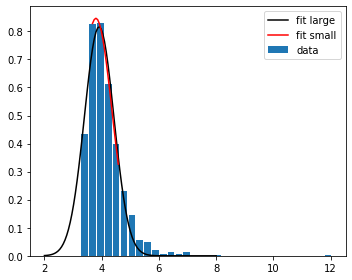

In [28]:
log_sample = lognorm.rvs(s=0.5, loc=3, scale=1, size=1000)
plt.figure(figsize=(5, 4))
h = plt.hist(log_sample, bins=32, rwidth=0.85, density=True, label='data')


def model_function2(x, *args):
    """
    Scaled PDF of the modeled normal distribution
    :param  x: value or array to evaluate the normal distribution
    :param *args: array containing ['A', 'mu', 'sigma'] that describe the normal distribution. 'A' is the scaling parameter
    :return: The value of the PDF of a normal distribution evaluated at 'x' with parameters 'mu' and 'sigma', scaled by 'A'
    """
    A, mu, sigma = args[0:3]
    return A * norm.pdf(x, mu, sigma)


x = h[1][:-1]+np.diff(h[1])[0]/2
y = h[0]
initial_guess = [0.95, 3.3, 0.3]
gauss_fit_large = curve_fit(model_function2, x, y, p0=initial_guess)
local = np.where(np.abs(x-np.mean(log_sample))<0.5)
gauss_fit_local = curve_fit(model_function2, x[local], y[local], p0=initial_guess)

x_arr = np.linspace(2, 8, 101)
local_fit_plot = np.where(np.abs(x_arr-np.mean(log_sample))<0.5)
plt.plot(x_arr, model_function2(x_arr, *gauss_fit_large[0]), '-', color='black', label='fit large')
plt.plot(x_arr[local_fit_plot], model_function2(x_arr[local_fit_plot], *gauss_fit_local[0]), '-', color='red', label='fit small')
plt.legend()
plt.tight_layout()

print('Expectation value:', lognorm.mean(s=0.5, loc=3, scale=1))
print('Sample mean:', np.mean(log_sample))
print('Gauss fit all data:', gauss_fit_large[0][1])
print('Gauss fit small sample around mean:', gauss_fit_local[0][1])

Fitting a Gaussian and gives a biased estimate on the mean of the sample. Fitting around the desired parameter does not help

## Bonus: Errors in x and y
So far, we considered uncertainties only on y. Consider the following data set with errors in both x and y. Try to fit a line to the data below, taking into account both errors. Compare with fits neglecting the x errors or both.  
  
Hint: A detailed solution is already on the moodle. You may chose if you want to try to write your own solution, implement a known solution (see references in solution notebook) or just try it with the scipy package ODR (orthogonal distance regression). 
https://docs.scipy.org/doc/scipy/reference/odr.html
  
The solution contains a python implementation of York's equation, comparison with ODR and MC tests.  
(Check straight_line_fit.ipynb)

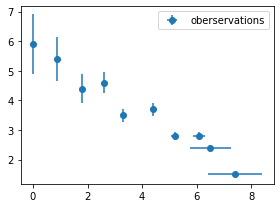

In [29]:
# Test data
X = np.array([0.0, 0.9, 1.8, 2.6, 3.3, 4.4, 5.2, 6.1, 6.5, 7.4])
Y = np.array([5.9, 5.4, 4.4, 4.6, 3.5, 3.7, 2.8, 2.8, 2.4, 1.5])
wX = np.array([1000, 1000, 500, 800, 200, 80, 60, 20, 1.8, 1])
wY = np.array([1, 1.8, 4, 8, 20, 20, 70, 70, 100, 500])
sigma_x = 1.0/np.sqrt(wX)
sigma_y = 1.0/np.sqrt(wY)

plt.figure(figsize=(4, 3))
plt.errorbar(X, Y, xerr=sigma_x, yerr=sigma_y, fmt='o', label='oberservations')
plt.legend()
plt.tight_layout()